In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Improved Pipeline Script for CPI Prediction
-------------------------------------------
Includes:
  - Data loading and cleaning
  - Optional lag feature creation (to capture time-series effects)
  - Model selection (Linear Regression, Ridge, Random Forest)
  - Optional ARIMA approach for comparison
  - Time-based split for training vs. testing
  - Basic evaluation (MSE, R^2) and plotting
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.dates as mdates

# If using ARIMA or SARIMAX for time-series
# from pmdarima import auto_arima
# or from statsmodels.tsa.arima.model import ARIMA

plt.rcParams['figure.figsize'] = (10, 6)

def load_and_clean_data(main_file="data/joined.csv",
                        og_file="data/output_gap.csv",
                        er_file="data/FRB_H10.csv"):
    """
    Loads CSV data from multiple sources, resamples monthly data,
    handles missing values, merges into a single DataFrame with a DatetimeIndex.
    Adjust or remove 'og_file' and 'er_file' merges if your 'joined.csv' already has them.
    Returns the final DataFrame.
    """
    # Example: Output Gap
    og = pd.read_csv(og_file)
    og["date"] = pd.to_datetime(og["year"], format="%Y")
    og_monthly = og.set_index("date").resample("MS").ffill().reset_index()
    og_monthly.drop(columns="year", inplace=True)

    # Example: Exchange Rates
    cxc = pd.read_csv(er_file, na_values=["ND"])
    cxc = cxc.rename(columns={"Time Period": "date", "JRXWTFB_N.B": "ER"})
    cxc["date"] = pd.to_datetime(cxc["date"], format="%d/%m/%Y")
    cxc = cxc.set_index("date").resample("MS").ffill().reset_index()

    # Main joined data
    df = pd.read_csv(main_file)
    df["date"] = pd.to_datetime(df["date"], format="%b-%y")

    # If 'joined.csv' doesn't already have OG or ER, merge them:
    # df = pd.merge(df, og_monthly, on="date", how="left")
    # df = pd.merge(df, cxc, on="date", how="left")

    # Set date as index
    df.set_index("date", inplace=True)

    # Fill missing values
    df = df.ffill().bfill()
    return df

def create_lag_features(df, cols, lags=1):
    """
    Creates lagged versions of specified columns (e.g. col_lag1, col_lag2,...).
    Helps capture delayed relationships in time-series data.
    """
    for col in cols:
        for i in range(1, lags + 1):
            df[f"{col}_lag{i}"] = df[col].shift(i)
    return df

def plot_predictions(y_true, pred_dict, split_date, title="CPI Prediction Comparison"):
    """
    Plots actual y values and multiple prediction series on the same figure.
    
    Parameters
    ----------
    y_true : pd.Series
        Actual CPI values indexed by date
    pred_dict : dict
        Dictionary of {model_name: predicted_values_series}
    split_date : str or pd.Timestamp
        The point separating training and testing sets (plotted as a vertical line)
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_true.index, y_true.values, label='Actual CPI', color='black')
    
    for label, preds in pred_dict.items():
        plt.plot(preds.index, preds.values, label=label, linestyle='--')
    
    plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Train/Test Split')
    plt.xlabel('Date')
    plt.ylabel('CPI')
    plt.title(title)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main_pipeline():
    # 1. Load & Clean Data
    df = load_and_clean_data()
    
    # 2. (Optional) Create lag features
    # Example: Add 1-month lag for IR, M2. Adjust as needed.
    df = create_lag_features(df, cols=["IR", "M2"], lags=1)
    
    # Drop any rows with missing values after lagging
    df.dropna(inplace=True)

    # 3. Define target and features
    target_col = "CPI"
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # 4. Scale features (optional but recommended for Ridge)
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    # 5. Time-based split
    split_date = "2023-01-01"
    X_train = X_scaled.loc[X_scaled.index < split_date]
    y_train = y.loc[y.index < split_date]
    X_test  = X_scaled.loc[X_scaled.index >= split_date]
    y_test  = y.loc[y.index >= split_date]

    # 6. Model Selection: Linear, Ridge, Random Forest, (Optional) ARIMA

    # 6.1 Linear Regression
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)

    # 6.2 Ridge (with minimal tuning)
    ridge_params = {'alpha': [0.01, 0.1, 1, 5, 10]}
    tscv = TimeSeriesSplit(n_splits=3)  # or any suitable value
    ridge_search = GridSearchCV(Ridge(), ridge_params, cv=tscv, scoring='neg_mean_squared_error')
    ridge_search.fit(X_train, y_train)
    best_ridge = ridge_search.best_estimator_

    # 6.3 Random Forest (nonlinear)
    # Could do param tuning similarly, e.g., for n_estimators, max_depth, etc.
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 6.4 Optional: ARIMA
    # from pmdarima import auto_arima
    # arima_model = auto_arima(y_train, seasonal=False, trace=False)
    # arima_model.fit(y_train)  
    # We'll compare direct MSE later if desired.

    # 7. Predict & Evaluate
    lin_pred = lin_model.predict(X_test)
    ridge_pred = best_ridge.predict(X_test)
    rf_pred = rf_model.predict(X_test)

    # If using ARIMA:
    # arima_pred = arima_model.predict(n_periods=len(y_test))

    # 8. Calculate MSE & R^2
    results = {}
    for name, pred in [("Linear", lin_pred),
                       ("Ridge", ridge_pred),
                       ("RandomForest", rf_pred)]:
                       # ("ARIMA", arima_pred) -- if used
        mse_val = mean_squared_error(y_test, pred)
        r2_val  = r2_score(y_test, pred)
        results[name] = {"MSE": mse_val, "R2": r2_val}
    
    # Print results
    for model_name, metrics in results.items():
        print(f"{model_name}: MSE={metrics['MSE']:.4f}, R²={metrics['R2']:.4f}")

    # Optionally show best hyperparams for ridge
    print("Best Ridge alpha:", ridge_search.best_params_['alpha'])

    # 9. Visualization
    pred_series = {
        "Linear": pd.Series(lin_pred, index=X_test.index),
        "Ridge": pd.Series(ridge_pred, index=X_test.index),
        "RandomForest": pd.Series(rf_pred, index=X_test.index),
        # "ARIMA": pd.Series(arima_pred, index=X_test.index)  # if used
    }
    plot_predictions(y, pred_series, split_date, title="CPI Prediction (Multiple Models)")


Linear: MSE=303.7190, R²=-9.8355
Ridge: MSE=300.8887, R²=-9.7345
RandomForest: MSE=519.3121, R²=-17.5270
Best Ridge alpha: 0.01


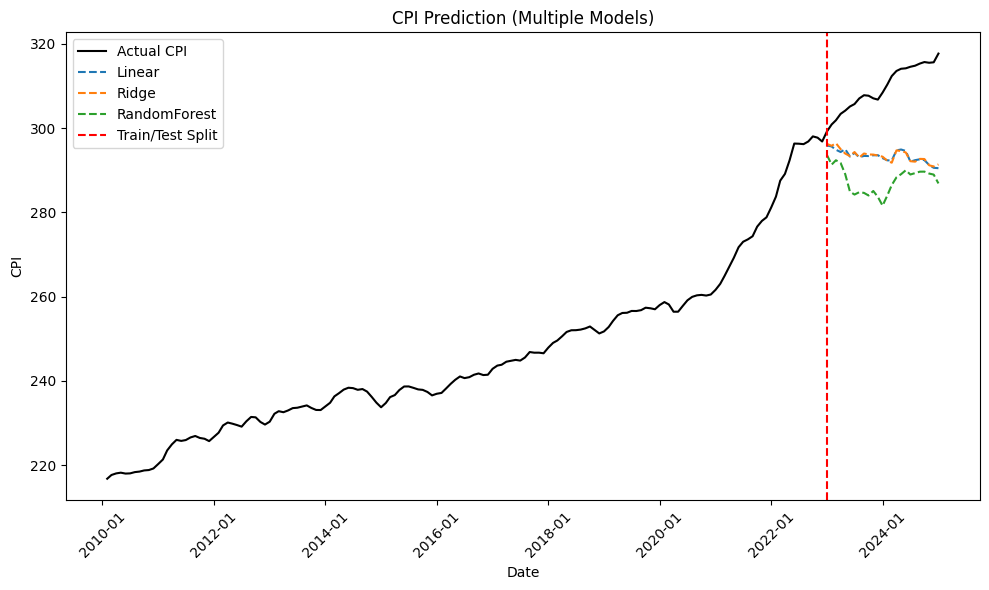

In [2]:
main_pipeline()